# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico III : Introducción al aprendizaje automático

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

**Recomendación:**
- Hay muchos ejemplos de código en internet, no se sientan obligados a implementar todo desde cero.

### Librerías

In [1]:
%%capture
!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install seaborn
!pip3 install requests
!pip3 install nltk
!pip3 install tqdm
!pip3 install plotly
!pip3 install sklearn
!pip3 install sentiment_analysis_spanish

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

Processing /home/kunan/.cache/pip/wheels/cd/22/66/fcfe16c783269151e68dfa0a25411b21a2d5d2106cda7dac1e/pymusixmatch-0.3-py3-none-any.whl
  Using cached stanza-1.1.1-py3-none-any.whl (227 kB)


### Dependencias y acceso a APIs

In [1]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch
import seaborn as sns
import tqdm
import plotly.express as px
import plotly.graph_objects as go
import requests
from collections import Counter
from nltk import ngrams, bigrams
import nltk
import itertools
import matplotlib.pyplot as plt
import json
import spacy
from sentiment_analysis_spanish import sentiment_analysis
from  statistics import median,mean


client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

# es = es_core_web_sm
#python -m spacy link es_core_news_sm es
nlp = spacy.load("es")

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
musixmatch = Musixmatch('1aa5272f4402bf2f082ad2f3958c2c62') # se puede reemplazar por otra API si da mejores resultados

sentiment = sentiment_analysis.SentimentAnalysisSpanish()


In [2]:
sns.set_context(context='paper')

### 1) Recopilar los datos obtenidos en los prácticos anteriores

Para esta parte consideraremos [la playlist colaborativa de la mentoría](https://open.spotify.com/playlist/2IuD0qZb14cji5y52crdsO?si=nfHRPDquQRyotEcXc4tG7Q), de esta obtendremos:
- Las features del audio de las canciones
- Las features textuales de sus letras

Además es necesario aplicar el mismo preprocesamiento que aplicamos en los prácticos anteriores para ambos tipos de features (el preprocesamiento del p1 a las features de audio y el de p2 al de features textuales) y obtener el género de cada canción, que en caso de ser más de uno para una canción el equipo deberá discutir una estrategia para estos casos y comentarla en el informe.

Luego, se separará al dataset resultante en **X** e **y**, donde:
- X es el conjunto de features
- y es la etiqueta, en este caso el género de la canción, que deberá ser codificado en valores del tipo **int**

Por último, se dividirá a estos dos conjuntos en los splits **train** y **test**

**Recomendaciones:**
- Obtener las features por separado y hacer un join de los datasets.
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)
- Si usan features categóricas, ENCODEARLAS!

# Dataset

## Music Features

In [3]:
#Aux funcs
def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        audio_features = sp.audio_features(track["song_id"])
        track["audio_features"] = audio_features[0]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]

def get_genres(artists_id):
    res = [genres_by_artist_id(x) for x in artists_id if genres_by_artist_id(x)!= []]
    if res != []:
        return res[0]
    return res

def add_track(track_id, songs): #track_id:str, songs:List[dict]
    track = sp.track(track_id)
    audio_features = sp.audio_features(track_id)
    row = {}
    row["song_name"] = track['name']
    row["song_id"] = track['id']
    row["artists"] = [x["name"] for x in track["artists"]]
    row["artists_id"] = [x["id"] for x in track["artists"]]
    row["album_name"] = track['album']['name']
    row["album_id"] = track['album']['id']
    row["audio_features"] = audio_features[0]
    row["genres"] = get_genres(row["artists_id"])
    songs.append(row)
    return songs


In [203]:
PLAYLIST_ID = "2IuD0qZb14cji5y52crdsO"
TEST_PLAYLIST_ID = "3gLmPh92AyeYDKYLaNC8uv"
songs = []

def add_songs_of_playlist(playlist_id,songs_array):

    print("This may take a while...")
    offset = 0
    playlist = sp.playlist_tracks(playlist_id,offset=offset,limit=100)
    batches = playlist["total"] // 100 + 1
    print("...downloading "+ str(playlist["total"]) + " songs")
    print("in "+str(batches)+ " batches")
    for j in tqdm.tqdm(range(batches)):
        for i in range(len(playlist["items"])):
            add_track(playlist["items"][i]["track"]["id"],songs_array)
        offset += len(playlist["items"])
        playlist = sp.playlist_tracks(playlist_id, offset=offset,limit=100)
    return

add_songs_of_playlist(PLAYLIST_ID,songs)

This may take a while...


  0%|          | 0/18 [00:00<?, ?it/s]

...downloading 1755 songs
in 18 batches


100%|██████████| 18/18 [31:41<00:00, 105.62s/it]


In [204]:
songs_original_df = pd.DataFrame(songs)
songs_original_df.count()

song_name         1755
song_id           1755
artists           1755
artists_id        1755
album_name        1755
album_id          1755
audio_features    1755
genres            1755
dtype: int64

In [205]:
#songs_original_df.to_csv("./base.csv",sep="#",index=False)


Checking dataframe's consistency.

In [206]:
songs_original_df[[x == [] for x in songs_original_df["genres"]]]

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres
48,Cambalache,3PI0FE7JUmEmEyN5YgKPZA,[Enrique Santos Discépolo],[0aPYs7yoiP2NtS5xNZXKjg],"Enrique Santos Discepolo ""El poeta del tango"" ...",59tn7tvd1M5XNWwV3TaVWC,"{'danceability': 0.492, 'energy': 0.541, 'key'...",[]
478,Sigue Feliz,1s0ndZpf2KeKEA08CsIFia,[Alonso y Bernardo],[5sskVxLnToHrnwTAICyVF5],"Narcos, Vol. 2 (More Music from the Netflix Or...",0EJRlYjvVcym9K4wrww9vB,"{'danceability': 0.672, 'energy': 0.625, 'key'...",[]
526,Celia,1rzFbkSvxQv6r3PSGjn7Ub,[Incas de Oro],[58wFXtpJxfvtigDaRWTNcj],Los Mejores Tinkus,4xDelBtEq3aJCU8hU6gFLB,"{'danceability': 0.675, 'energy': 0.477, 'key'...",[]
600,Arteria Ulnar,7kGsNBECFyCQ0fBJn2KB6o,[Té de Brujas],[39BvzssARgDTZ1Kf0uqNfj],Arteria Ulnar,5g5rgxGPlCnRTrYyf173fp,"{'danceability': 0.497, 'energy': 0.651, 'key'...",[]
604,No Le Ganamos a Nadie,0F0I189uNvQBdgy1SFNOec,[Literal],[0Ec1MqHP5MENR7rK3DtO3G],No Le Ganamos a Nadie,43moEeCjsTjk6N25XRin0S,"{'danceability': 0.568, 'energy': 0.938, 'key'...",[]
606,Contratiempos,50GbEo3clyzJRzuAjIFWdz,[Parientes],[76lUSSvc6Z83CLrIVB7YrE],Contratiempos,3F6da9yP7HMGwl88egAqZ5,"{'danceability': 0.549, 'energy': 0.778, 'key'...",[]
613,Si Tú No Estas (Nashville),3TCpMjVi4DVzbc5dXLpEeX,[Stokoff],[03wfTeoZex93T5TPxWo3B9],Si Tú No Estas (Nashville),2fNd57gzWCMwsNVG0K5YQy,"{'danceability': 0.545, 'energy': 0.652, 'key'...",[]
617,Una Nueva Realidad,3CQinOLvOg1vMvP9a060xV,[Scones de la Chola],[1n0013t3w2RbIqSYarnPGS],Una Nueva Realidad,6NCW2haZteRywEWZSzc7in,"{'danceability': 0.536, 'energy': 0.571, 'key'...",[]
628,Dale!,48EI8HkseqMBYQw8yl4WL3,[La Extrema Vanguardia],[3p1OOKD3Rs8JsT9I76mACt],Epe,4Bgue5pbIMGEZ61SoULBMr,"{'danceability': 0.464, 'energy': 0.864, 'key'...",[]
637,Si Me Dijeras,0NhFqADNG4OABBBEtxW0WM,[Vozenoff],[0hASTHk8Lmdj2zAHvkfsfW],Si Me Dijeras,6gyIUgOHK85AQswoDcLDDw,"{'danceability': 0.534, 'energy': 0.747, 'key'...",[]


In [207]:
songs_original_df[[x == [] for x in songs_original_df["genres"]]].count()

song_name         19
song_id           19
artists           19
artists_id        19
album_name        19
album_id          19
audio_features    19
genres            19
dtype: int64

These cells don't have a genre since Spotify hasn't assigned a genre to their corresponding artists. 
These edge cases will be corrected by hand trying to find the closest match by listening to each song and finding a similiar artist that has an assigned genre in Spotify, if that is possible.

In [209]:
sp.artist("4Apvih9OZt9ghebGFIVcXI")
get_genres(["64DFKvGarD5nmkfaIiiakf"])

['cuarteto']

In [210]:
sanitized_df = songs_original_df.copy()
sanitized_df.iloc[48]["genres"] = get_genres(["7Cg2eqV6oHNE0P54WfajIX"]) #like julio sosa
sanitized_df.iloc[478]["genres"] = 'folklore'
#sanitized_df.iloc[498]["genres"] = get_genres(["4Apvih9OZt9ghebGFIVcXI"]) #like los del suquia
sanitized_df.iloc[526]["genres"] = get_genres(["0iutktJLkNNtErs8c3EoF6"]) #like los tekis
sanitized_df.iloc[600]["genres"] = get_genres(["7okwEbXzyT2VffBmyQBWLz"]) #like maná
sanitized_df.iloc[604]["genres"] = get_genres(["3HrbmsYpKjWH1lzhad7alj"]) #like los autenticos decadentes
sanitized_df.iloc[606]["genres"] = get_genres(["1vumST4jmwQla7lkbLKDUw"]) #like foxley
sanitized_df.iloc[613]["genres"] = get_genres(["5f5Wlazt9jmI75fK5nPpd6"]) #like 8 segundos
sanitized_df.iloc[617]["genres"] = get_genres(["0SnyKkoyBaB2fG8IJH4xmU"]) #like los piojos
sanitized_df.iloc[628]["genres"] = get_genres(["0SnyKkoyBaB2fG8IJH4xmU"]) #like los piojos
sanitized_df.iloc[637]["genres"] = get_genres(["2wjmZuSHtRx96Qxb8HiP2o"]) #like los guasones
sanitized_df.iloc[647]["genres"] = get_genres(["0SnyKkoyBaB2fG8IJH4xmU"]) #like los piojos
sanitized_df.iloc[652]["genres"] = get_genres(["54YdJC33Ztc1CNIuodmyUb"]) #like leo garcia
sanitized_df.iloc[663]["genres"] = get_genres(["1AvkrI2S7knrbaZxydvc9B"]) #like mala fama

sanitized_df.iloc[1504]["genres"] = get_genres(["64DFKvGarD5nmkfaIiiakf"]) #like la mona
sanitized_df.iloc[1521]["genres"] = get_genres(["64DFKvGarD5nmkfaIiiakf"]) #like la mona
sanitized_df.iloc[1523]["genres"] = get_genres(["64DFKvGarD5nmkfaIiiakf"]) #like la mona
sanitized_df.iloc[1526]["genres"] = get_genres(["64DFKvGarD5nmkfaIiiakf"]) #like la mona
sanitized_df.iloc[1538]["genres"] = get_genres(["64DFKvGarD5nmkfaIiiakf"]) #like la mona
sanitized_df.iloc[1541]["genres"] = get_genres(["64DFKvGarD5nmkfaIiiakf"]) #like la mona
sanitized_df[[x == [] for x in sanitized_df["genres"]]]

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres


In [211]:
sanitized_df.count()

song_name         1755
song_id           1755
artists           1755
artists_id        1755
album_name        1755
album_id          1755
audio_features    1755
genres            1755
dtype: int64

No nulls in any other column

In [212]:
columns = sanitized_df.columns

for column in columns:
    if sanitized_df[[x == [] for x in sanitized_df[column]]].empty:
        print("No nulls in column ", column)
    else:
        print(">>>>>>> Found nulls in column", column)

No nulls in column  song_name
No nulls in column  song_id
No nulls in column  artists
No nulls in column  artists_id
No nulls in column  album_name
No nulls in column  album_id
No nulls in column  audio_features
No nulls in column  genres


Let's remove possible duplicated songs

In [213]:
#duplicated_songs = songs_original_df[songs_original_df["song_id"].duplicated(keep='last')]
#duplicated_songs
sanitized_df[sanitized_df.duplicated(subset=["song_id"])==True].count()[0]
#songs_original_df.duplicated(subset=["song_id"],keep='first').any()
#songs_original_df[songs_original_df["song_id"]=="2TNV1bPTWhKTRTVAghIszh"]

20

We find two duplicated tracks of the same song_id in the dataset.
Let's remove them

In [214]:
songs_df = sanitized_df[sanitized_df["song_id"].duplicated(keep='last') != True]
if not songs_df.duplicated(subset=["song_id"]).any():
    print(f"no duplicated records found in {len(songs_df)} records")

no duplicated records found in 1735 records


Let's make a backup file to not have to run all that code again

In [215]:
songs_df.to_csv("./songs_df.csv")

In [216]:
audio_features_base = pd.DataFrame(list(songs_original_df["audio_features"].values))
audio_features_description = audio_features_base.describe()
audio_features_description

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1.755000e+03,1755.000000
mean,0.585561,0.719249,5.274074,-6.488591,0.611966,0.070666,0.237802,0.031040,0.241244,0.619261,126.232073,2.307568e+05,3.937322
std,0.153703,0.180207,3.544727,2.817251,0.487441,0.064718,0.229648,0.130680,0.226563,0.234545,30.503676,8.823704e+04,0.310502
min,0.078000,0.033500,0.000000,-28.480000,0.000000,0.022100,0.000002,0.000000,0.022000,0.029200,60.026000,3.893300e+04,1.000000
25%,0.491000,0.608000,2.000000,-7.784500,0.000000,0.033200,0.049900,0.000000,0.097500,0.436000,97.884500,1.913570e+05,4.000000
50%,0.608000,0.752000,5.000000,-6.057000,1.000000,0.046600,0.170000,0.000002,0.142000,0.650000,128.048000,2.222830e+05,4.000000
75%,0.696500,0.863000,9.000000,-4.582000,1.000000,0.078600,0.360500,0.000299,0.309000,0.816500,148.078000,2.560925e+05,4.000000
max,0.945000,0.995000,11.000000,-0.767000,1.000000,0.514000,0.982000,0.944000,0.991000,0.976000,205.938000,1.500920e+06,5.000000


Preeliminary analysis of the dataset

In [223]:

def songs_of_description(statistic):
    row = audio_features_description.loc[statistic]
    keys = row.keys()
    tracks_of_row = []
    for key in keys:
        track = track_by_feature(key,row[key]).to_dict()['song_name']
        track = list(track.values())[0]
        tracks_of_row.append({key: track})
    return tracks_of_row
#example use
#songs_of_description("min")

#songs_of_description("max")

In [224]:
#songs_of_description("min")

## Lyrics

In [225]:
songs_df.count()

song_name         1735
song_id           1735
artists           1735
artists_id        1735
album_name        1735
album_id          1735
audio_features    1735
genres            1735
dtype: int64

analisis previo:
distribución de los géneros en el dataset.

Considerations: the performance of using the mean and median of the sentiment of the sentences that comprise each song's lyrics was compared to the performance of using the whole song as a long sentence.

The following function can be used to make this comparision:

In [5]:

def compare_performance_mean_vs_median_vs_whole_song(songs_df):
    all_songs = songs_df.copy()
    all_songs = all_songs.head(5).T.to_dict().values()
    songs_sentiments = []
    for song in all_songs:
        print(song["song_name"])
        response = requests.get(song_url_for_request(song["artists"][0],song["song_name"])).json()
        json_data = response 
        lyrics_raw = json_data["lyrics"]
        whole_lyrics_way = lyrics_raw.replace("\n", " ") #for whole sentence
        lyrics_raw = lyrics_raw.split("\n") #for each sentence
        # lo siguiente es por si se necesita analizar palabra por palabra
        #lyrics_raw = [sentence.split(" ") for sentence in lyrics_raw]
        sentiments_tmp = []
        for sentence in lyrics_raw:
            thing = sentiment.sentiment(sentence.lower())
            sentiments_tmp.append(thing)
        whole_song_sent = sentiment.sentiment(whole_lyrics_way)
        sent_mean = mean(sentiments_tmp)
        sent_median = median(sentiments_tmp)
        print("mean ",sent_mean, " median ",sent_median)
        print("the other way: ", whole_song_sent)
        print("\n\n")
        song_sent_statistics = {"song":song["song_name"],"mean":sent_mean,"median":sent_median,"whole_song":whole_song_sent}
        songs_sentiments.append(song_sent_statistics)
    return songs_sentiments


In [6]:
# aux methods
def song_url_for_request(artist, song_title):
    return "https://api.lyrics.ovh/v1/" + artist + '/' + song_title #str
    # example use:
    # requests.get(song_url_for_request("Death Grips", "Hacker"))
    

def add_lyrics_to_data(all_songs):
    songs_without_lyrics = []
    without_lyrics = 0
    for song in tqdm.tqdm(all_songs):
        try:
            response = requests.get(song_url_for_request(song["artists"][0],song["song_name"])).json()
            json_data = response #json.loads(response.content)
            lyrics_raw = json_data["lyrics"]
            lyrics_raw = lyrics_raw.replace("\n", " ") #for whole sentence
            song_sentiment = sentiment.sentiment(lyrics_raw)
            song["lyrics_sentiment"]= round(song_sentiment,4)
        except: #found a song without lyrics!
            without_lyrics +=1
            song["lyrics_sentiment"]=None
            songs_without_lyrics.append(song)
    print(f"There are {without_lyrics} songs without lyrics")
    return all_songs

In [123]:
all_songs = songs_df.copy()
all_songs = all_songs.T.to_dict().values()
all_songs = add_lyrics_to_data(all_songs)











  0%|          | 0/1170 [00:00<?, ?it/s]








  0%|          | 1/1170 [00:01<26:19,  1.35s/it]








  0%|          | 2/1170 [00:02<25:16,  1.30s/it]








  0%|          | 3/1170 [00:03<25:17,  1.30s/it]








  0%|          | 4/1170 [00:05<24:39,  1.27s/it]








  0%|          | 5/1170 [00:06<24:25,  1.26s/it]








  1%|          | 6/1170 [00:07<24:23,  1.26s/it]








  1%|          | 7/1170 [00:08<24:10,  1.25s/it]








  1%|          | 8/1170 [00:10<24:27,  1.26s/it]








  1%|          | 9/1170 [00:11<25:56,  1.34s/it]








  1%|          | 10/1170 [00:12<25:50,  1.34s/it]








  1%|          | 11/1170 [00:14<28:12,  1.46s/it]








  1%|          | 12/1170 [00:15<27:14,  1.41s/it]








  1%|          | 13/1170 [00:17<28:06,  1.46s/it]








  1%|          | 14/1170 [00:18<28:12,  1.46s/it]








  1%|▏         | 15/1170 [00:20<29:27,  1.53s/it]








  1%|▏         | 16/1170 [00:21<27:56,  1.45s/it]








  1%|▏         | 17/117

 16%|█▋        | 191/1170 [04:39<23:54,  1.47s/it]








 16%|█▋        | 192/1170 [04:40<23:40,  1.45s/it]








 16%|█▋        | 193/1170 [04:42<23:42,  1.46s/it]








 17%|█▋        | 194/1170 [04:43<23:54,  1.47s/it]








 17%|█▋        | 195/1170 [04:45<23:13,  1.43s/it]








 17%|█▋        | 196/1170 [04:46<23:14,  1.43s/it]








 17%|█▋        | 197/1170 [04:47<23:12,  1.43s/it]








 17%|█▋        | 198/1170 [04:49<23:42,  1.46s/it]








 17%|█▋        | 199/1170 [04:50<23:46,  1.47s/it]








 17%|█▋        | 200/1170 [04:52<23:20,  1.44s/it]








 17%|█▋        | 201/1170 [04:53<23:32,  1.46s/it]








 17%|█▋        | 202/1170 [04:55<22:34,  1.40s/it]








 17%|█▋        | 203/1170 [04:56<21:26,  1.33s/it]








 17%|█▋        | 204/1170 [04:57<22:15,  1.38s/it]








 18%|█▊        | 205/1170 [04:59<21:56,  1.36s/it]








 18%|█▊        | 206/1170 [05:00<21:55,  1.36s/it]








 18%|█▊        | 207/1170 [05:01<21:40,  1.35s/it]







 33%|███▎      | 381/1170 [09:09<18:46,  1.43s/it]








 33%|███▎      | 382/1170 [09:10<18:46,  1.43s/it]








 33%|███▎      | 383/1170 [09:12<19:16,  1.47s/it]








 33%|███▎      | 384/1170 [09:13<19:24,  1.48s/it]








 33%|███▎      | 385/1170 [09:15<19:35,  1.50s/it]








 33%|███▎      | 386/1170 [09:16<19:59,  1.53s/it]








 33%|███▎      | 387/1170 [09:18<19:29,  1.49s/it]








 33%|███▎      | 388/1170 [09:19<18:43,  1.44s/it]








 33%|███▎      | 389/1170 [09:20<18:16,  1.40s/it]








 33%|███▎      | 390/1170 [09:22<19:19,  1.49s/it]








 33%|███▎      | 391/1170 [09:23<18:53,  1.45s/it]








 34%|███▎      | 392/1170 [09:25<18:19,  1.41s/it]








 34%|███▎      | 393/1170 [09:26<18:08,  1.40s/it]








 34%|███▎      | 394/1170 [09:27<17:48,  1.38s/it]








 34%|███▍      | 395/1170 [09:29<17:35,  1.36s/it]








 34%|███▍      | 396/1170 [09:30<16:48,  1.30s/it]








 34%|███▍      | 397/1170 [09:31<16:50,  1.31s/it]







 49%|████▉     | 571/1170 [13:50<13:16,  1.33s/it]








 49%|████▉     | 572/1170 [13:52<13:53,  1.39s/it]








 49%|████▉     | 573/1170 [13:53<13:32,  1.36s/it]








 49%|████▉     | 574/1170 [13:54<13:47,  1.39s/it]








 49%|████▉     | 575/1170 [13:56<13:28,  1.36s/it]








 49%|████▉     | 576/1170 [13:57<13:06,  1.32s/it]








 49%|████▉     | 577/1170 [13:58<12:54,  1.31s/it]








 49%|████▉     | 578/1170 [13:59<12:26,  1.26s/it]








 49%|████▉     | 579/1170 [14:01<12:17,  1.25s/it]








 50%|████▉     | 580/1170 [14:02<12:51,  1.31s/it]








 50%|████▉     | 581/1170 [14:03<12:45,  1.30s/it]








 50%|████▉     | 582/1170 [14:05<12:49,  1.31s/it]








 50%|████▉     | 583/1170 [14:06<12:51,  1.31s/it]








 50%|████▉     | 584/1170 [14:07<12:56,  1.32s/it]








 50%|█████     | 585/1170 [14:09<12:51,  1.32s/it]








 50%|█████     | 586/1170 [14:10<12:59,  1.33s/it]








 50%|█████     | 587/1170 [14:11<12:48,  1.32s/it]







 65%|██████▌   | 761/1170 [18:09<09:09,  1.34s/it]








 65%|██████▌   | 762/1170 [18:11<09:05,  1.34s/it]








 65%|██████▌   | 763/1170 [18:12<09:04,  1.34s/it]








 65%|██████▌   | 764/1170 [18:13<08:46,  1.30s/it]








 65%|██████▌   | 765/1170 [18:15<08:39,  1.28s/it]








 65%|██████▌   | 766/1170 [18:16<08:42,  1.29s/it]








 66%|██████▌   | 767/1170 [18:17<08:32,  1.27s/it]








 66%|██████▌   | 768/1170 [18:19<08:52,  1.32s/it]








 66%|██████▌   | 769/1170 [18:20<08:38,  1.29s/it]








 66%|██████▌   | 770/1170 [18:21<08:54,  1.34s/it]








 66%|██████▌   | 771/1170 [18:22<08:39,  1.30s/it]








 66%|██████▌   | 772/1170 [18:24<08:23,  1.27s/it]








 66%|██████▌   | 773/1170 [18:25<08:24,  1.27s/it]








 66%|██████▌   | 774/1170 [18:26<08:47,  1.33s/it]








 66%|██████▌   | 775/1170 [18:28<08:30,  1.29s/it]








 66%|██████▋   | 776/1170 [18:29<08:56,  1.36s/it]








 66%|██████▋   | 777/1170 [18:31<09:26,  1.44s/it]







 81%|████████▏ | 951/1170 [22:26<04:48,  1.32s/it]








 81%|████████▏ | 952/1170 [22:27<04:45,  1.31s/it]








 81%|████████▏ | 953/1170 [22:28<05:01,  1.39s/it]








 82%|████████▏ | 954/1170 [22:30<04:56,  1.37s/it]








 82%|████████▏ | 955/1170 [22:31<04:52,  1.36s/it]








 82%|████████▏ | 956/1170 [22:32<04:49,  1.35s/it]








 82%|████████▏ | 957/1170 [22:34<04:46,  1.34s/it]








 82%|████████▏ | 958/1170 [22:35<04:45,  1.35s/it]








 82%|████████▏ | 959/1170 [22:36<04:35,  1.31s/it]








 82%|████████▏ | 960/1170 [22:38<04:36,  1.32s/it]








 82%|████████▏ | 961/1170 [22:39<04:35,  1.32s/it]








 82%|████████▏ | 962/1170 [22:40<04:39,  1.34s/it]








 82%|████████▏ | 963/1170 [22:42<04:35,  1.33s/it]








 82%|████████▏ | 964/1170 [22:43<04:31,  1.32s/it]








 82%|████████▏ | 965/1170 [22:44<04:32,  1.33s/it]








 83%|████████▎ | 966/1170 [22:46<04:29,  1.32s/it]








 83%|████████▎ | 967/1170 [22:47<04:25,  1.31s/it]







 97%|█████████▋| 1139/1170 [26:46<00:45,  1.48s/it]








 97%|█████████▋| 1140/1170 [26:47<00:44,  1.49s/it]








 98%|█████████▊| 1141/1170 [26:49<00:42,  1.46s/it]








 98%|█████████▊| 1142/1170 [26:50<00:41,  1.50s/it]








 98%|█████████▊| 1143/1170 [26:52<00:40,  1.50s/it]








 98%|█████████▊| 1144/1170 [26:53<00:38,  1.50s/it]








 98%|█████████▊| 1145/1170 [26:55<00:36,  1.47s/it]








 98%|█████████▊| 1146/1170 [26:56<00:36,  1.50s/it]








 98%|█████████▊| 1147/1170 [26:58<00:32,  1.43s/it]








 98%|█████████▊| 1148/1170 [26:59<00:31,  1.44s/it]








 98%|█████████▊| 1149/1170 [27:00<00:29,  1.40s/it]








 98%|█████████▊| 1150/1170 [27:02<00:28,  1.42s/it]








 98%|█████████▊| 1151/1170 [27:03<00:26,  1.42s/it]








 98%|█████████▊| 1152/1170 [27:04<00:24,  1.35s/it]








 99%|█████████▊| 1153/1170 [27:06<00:23,  1.38s/it]








 99%|█████████▊| 1154/1170 [27:07<00:21,  1.36s/it]








 99%|█████████▊| 1155/1170 [27:09<00:20,

There are 377 songs without lyrics


In [133]:
songs_base = pd.DataFrame(all_songs)
#del songs_base["lyrics"]
#songs_base.to_csv("./songs_base_with_lyrics.csv")

In [134]:
print(f"Before sanitization {len(all_songs)}")
songs_base.sample(5)

Before sanitization 1170


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment
1117,Me Extrañarás,1e4PRJWfSorO7RLgqDRvYR,"[Rodrigo, Ulises Bueno]","[235Vf4hkmwvxjVEMuCbRxm, 2UqRkW2wfEkZmyvKyTTv2W]",Me Extrañarás,366XQK2TfrjoWv17w2B9eD,"{'danceability': 0.53, 'energy': 0.918, 'key':...","[argentine rock, cuarteto, cumbia pop, cumbia ...",NaN
773,Deseos de Cosas Imposibles (with Abel Pintos) ...,42rtLutZjrQGmzxZhN5YFA,"[La Oreja de Van Gogh, Abel Pintos]","[4U7lXyKdSf1JbM1aXvsodC, 6HTUcOExehqydqa7C3usAa]",Primera Fila,7pC1BMjl8x5Yr60xX2tyZh,"{'danceability': 0.608, 'energy': 0.509, 'key'...","[latin, latin arena pop, latin pop, mexican po...",0.0001
436,Para Que Sigamos siendo,1eqa7UxRqR59lR5SQ79lZg,[Eruca Sativa],[2RPNbhguRnI9uqahGYcUc6],La Carne,4irdwHtE3LGlYkPzxRQGln,"{'danceability': 0.593, 'energy': 0.715, 'key'...","[argentine indie, argentine metal, argentine r...",0.0000
1075,Soy de la Esquina,6q8EF1C7ZzNOpgNye7ycvh,[Hermetica],[6j6Ld5h0aFgH0VQWQNazS7],Victimas del Vaciamiento,70Bq990gBdpLDzx7M8r28i,"{'danceability': 0.372, 'energy': 0.83, 'key':...","[argentine heavy metal, argentine metal, argen...",0.0000
1108,Dramas Gratis,31kX39lcYsiGEaVPRs5Pfb,"[Damas Gratis, Andrés Calamaro]","[3YeBTR1Q1rUxKguz4jP6UV, 3tAICgiSR5PfYY4B8qsoAU]",Esquivando el Exito,0OkF4frqfEXWFZDwgSWfIN,"{'danceability': 0.602, 'energy': 0.914, 'key'...",[cumbia villera],0.0000


In [141]:
# sanitize
bool_series = pd.notnull(songs_base["lyrics_sentiment"])
songs_base = songs_base[bool_series]
print(f"After sanitization {len(songs_base)}")
songs_base.head(3)

After sanitization 793


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],[4SQdUpG4f7UbkJG3cJ2Iyj],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...","[art pop, dance pop, deconstructed club, elect...",0.0055
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,[Arca],[4SQdUpG4f7UbkJG3cJ2Iyj],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...","[art pop, dance pop, deconstructed club, elect...",0.3901
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,[Arca],[4SQdUpG4f7UbkJG3cJ2Iyj],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...","[art pop, dance pop, deconstructed club, elect...",0.0000


In [ ]:
songs_base.to_csv("./final.csv",sep="#",index=False)


In [57]:
songs_base = pd.read_csv("./songs_base_with_lyrics_sanitized_final.csv",sep="#")
#let's get back our genres
songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))


In [10]:
songs_base.head(5)

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...","['art pop', 'dance pop', 'deconstructed club',...",0.0055
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...","['art pop', 'dance pop', 'deconstructed club',...",0.3901
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...","['art pop', 'dance pop', 'deconstructed club',...",0.0000
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,['Rocío Dúrcal'],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...","['bolero', 'cancion melodica', 'grupera', 'lat...",0.0057
4,Querida,5ySxlyvySBhIEvoO2xx7uT,['Juan Gabriel'],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...","['cancion melodica', 'latin', 'latin pop']",0.0000


Let's try to simplify the process by using a unique genre of our dataset for each song

In [13]:
from sklearn.neighbors import KNeighborsClassifier

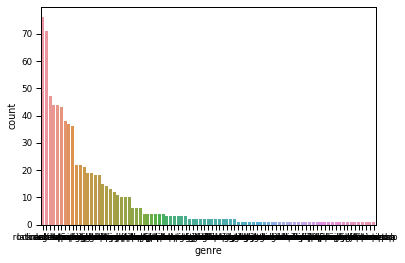

In [110]:
simple_df = songs_base.copy()

# using a random genre
import random
random_simple_df = simple_df.copy()
random_simple_df["genres"] = simple_df["genres"].apply(lambda x: random.choice(x))
random_dist = random_simple_df["genres"].value_counts()
random_dist_df = pd.DataFrame({'genre':random_dist.index, 'count':random_dist.values})
#columns=["genre", "counts"])
random_dist_df
sns.barplot(x=random_dist_df["genre"],y=random_dist_df["count"])

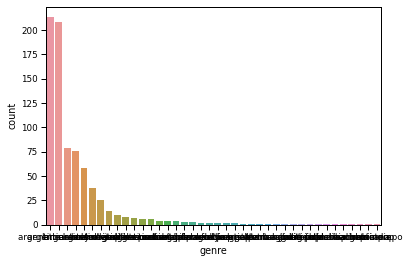

In [121]:
first_df = simple_df.copy()
first_df["genres"] = first_df["genres"].apply(lambda x: x[0])
first_dist = first_df["genres"].value_counts()
first_dist_df = pd.DataFrame({'genre':first_dist.index, 'count':first_dist.values})
#columns=["genre", "counts"])
#simple_dist_df
sns.barplot(x=first_dist_df["genre"],y=first_dist_df["count"])


using a random choice we get a slightly more balanced dataset

In [176]:
import ast

df = random_simple_df.copy()
audio_thing= df["audio_features"].apply(lambda x: ast.literal_eval(x))
audio_features_base = pd.DataFrame(list(audio_thing))
audio_features = audio_features_base.columns
#df.drop(["audio_features"],axis=1, inplace=True)
df = pd.concat([df,audio_features_base],axis=1)
df.head(5)

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...",electropop,0.0055,0.161,...,0.371,0.0926,161.092,audio_features,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/tracks/7j9DYPyCuvSA...,https://api.spotify.com/v1/audio-analysis/7j9D...,233079,5
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...",indietronica,0.3901,0.230,...,0.115,0.0834,80.793,audio_features,1cwTMSQeMaA9fVKEF1iWeD,spotify:track:1cwTMSQeMaA9fVKEF1iWeD,https://api.spotify.com/v1/tracks/1cwTMSQeMaA9...,https://api.spotify.com/v1/audio-analysis/1cwT...,216905,5
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...",dance pop,0.0000,0.289,...,0.124,0.0391,124.835,audio_features,0aL27vskbMpwsMGUkHm3Zf,spotify:track:0aL27vskbMpwsMGUkHm3Zf,https://api.spotify.com/v1/tracks/0aL27vskbMpw...,https://api.spotify.com/v1/audio-analysis/0aL2...,215773,3
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,['Rocío Dúrcal'],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...",cancion melodica,0.0057,0.499,...,0.576,0.4640,88.140,audio_features,2kfSFdq2h0xLXq01em1zc7,spotify:track:2kfSFdq2h0xLXq01em1zc7,https://api.spotify.com/v1/tracks/2kfSFdq2h0xL...,https://api.spotify.com/v1/audio-analysis/2kfS...,219107,4
4,Querida,5ySxlyvySBhIEvoO2xx7uT,['Juan Gabriel'],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...",cancion melodica,0.0000,0.528,...,0.110,0.4600,89.089,audio_features,5ySxlyvySBhIEvoO2xx7uT,spotify:track:5ySxlyvySBhIEvoO2xx7uT,https://api.spotify.com/v1/tracks/5ySxlyvySBhI...,https://api.spotify.com/v1/audio-analysis/5ySx...,328320,4


dataset split

In [177]:
other = pd.concat([df[audio_features], df['lyrics_sentiment']], axis=1)
sanitized = other.drop(["uri", "analysis_url", "track_href", "id", "type"],1)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [188]:
from sklearn import model_selection, tree
X = sanitized
y = df["genres"]
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)


## Decision Trees

In [189]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)

In [190]:
predictions = clf.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train == predictions))/float(y_train.size)*100))

Accuracy: 13 


In [192]:
predictions = clf.predict(X_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

Accuracy: 14 


In [202]:
score = clf.score(X_valid, y_valid)
score

0.14285714285714285

In [198]:
predicts = clf.predict(X_valid.head(1))
predicts
#track_by_feature("danceability", 0.631)

array(['cuarteto'], dtype=object)

In [200]:
#more aux functions
def track_by_feature(feature, value):
    track_id = audio_features_base[audio_features_base[feature]==value]['id']
    track_id = track_id.values.item(0)
    return df[df['song_id']== track_id]
#example use: 
#print(track_by_feature("valence",0.039100))
#track_by_feature("speechiness",0.492000)


In [201]:
track_by_feature("danceability", 0.631)

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
96,Lluvia,09O9vdg73P50pPHC2FiWzV,['La Mona Jimenez'],['64DFKvGarD5nmkfaIiiakf'],Discografía Completa - Volumen 3,1Cs9XYXDQvBlEqDN3jDoHP,"{'danceability': 0.631, 'energy': 0.94, 'key':...",cuarteto,0.0001,0.631,...,0.0673,0.817,150.073,audio_features,09O9vdg73P50pPHC2FiWzV,spotify:track:09O9vdg73P50pPHC2FiWzV,https://api.spotify.com/v1/tracks/09O9vdg73P50...,https://api.spotify.com/v1/audio-analysis/09O9...,286493,4


In [ ]:
songs_of_description()

#### Notas del profe

Primero, la letra en sí no se usa, igual que el nombre de la canción. Los n gramas tampoco.

Lo que sí se puede usar son datos obtenidos en base al texto de las canciones, el ejemplo por excelencia es hacer sentiment analysis

Ver
https://elitedatascience.com/python-nlp-libraries


### 2) Elegir tres modelos de clasificadores multiclase

Aquí escogeremos tres modelos diferentes y luego compararemos su rendimiento para esta tarea. El procedimiento será el siguiente:
- Inicializar los modelos
- Entrenarlos usando el split **train** de los datos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

### 3) Informe: Comparar el rendimiento de los modelos

Una vez entrenados los tres modelos, compararemos su rendimiento:
- Correr los modelos usando el split **test**
- Obtener el reporte de clasificación y la matriz de confusión para cada modelo
- Graficar llevando a 2 dimensiones nuestro split **test** pintando con colores diferentes según la etiqueta correspondiente.
- Graficar de manera similar los resultados obtenidos con cada clasificador y sobre esto la función de clasificación obtenida.
- Guardar los modelos usando **pickle**
- Discutir los resultados obtenidos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

### 4) Tareas adicionales:

Estas tareas servirán para extrapolar un poco el trabajo básico, y también sumarán puntos extra. Deben elegir una o más de las siguientes:
-  Análisis sobre el balance de clases del dataset, balanceo usando **subsampling** u **oversampling** y comparación de resultados vs el modelo básico
- Optimización de hiperparámetros y comparación de resultados vs el modelo básico
- Graficar importancia de features
- Graficar correlación de features

**Recomendación:**
- Hacer varias ahora puede ahorrarles tiempo en el futuro

In [37]:
#problemas de spotify's genres
get_genres(["0iutktJLkNNtErs8c3EoF6"])

['cumbia andina mexicana', 'folclore jujeno', 'folklore argentino']